In [1]:
import numpy as np
import gym
import matplotlib.pyplot as plt
import tqdm

In [2]:
%matplotlib notebook

In [3]:
def draw(steps, values):
    fig, ax = plt.subplots(figsize=(4,4))
    ax.plot(steps, values)
    ax.set_xlabel('Количество эпизодов')
    ax.set_ylabel('Средний доход')
    ax.grid()
    plt.ion()
    fig.show()

# Часть 1

## Simple policy

In [4]:
env = gym.make('Blackjack-v0')

In [5]:
env.observation_space.spaces

(Discrete(32), Discrete(11), Discrete(2))

In [6]:
dim = (32, 11, 2)

In [7]:
simple_policy = np.zeros(dim, dtype=int)

In [8]:
simple_policy[0:16, ::, ::] = 1

In [9]:
def observation_clean(observation):
    return (observation[0], observation[1], int(observation[2]))

In [10]:
def simple_play(n):
    env = gym.make('Blackjack-v0')
    all_rewards = 0
    for i in range(n):
        obs = env.reset()
        obs, reward, done, info = env.step(simple_policy[observation_clean(obs)])
        all_rewards += reward
        while not done:
            obs, reward, done, info = env.step(simple_policy[observation_clean(obs)])
            all_rewards += reward
    return all_rewards / n
        
    

In [11]:
simple_play(10000)

-0.0649

## Off-policy Monte Carlo Control

In [12]:
class Agent:
    def __init__(self, dim, na, eps=0.05):
        self.eps = eps
        self.dim = dim
        self.na = na
        self.policy = np.zeros(self.dim, dtype=int)
        self.actions = np.arange(na)
        self.Q = np.zeros((*dim, na), dtype=float)
        
        
    def action(self, obs):
        if np.random.rand() <= self.eps:
            return np.random.choice(self.actions)
        return self.policy[self._clean(obs)]
        #return self.policy[obs]
    
    @staticmethod
    def _clean(observation):
        return tuple(map(int, observation))
        
        
    
        

In [13]:
def get_episod(agent, env):
    episod = []
    state = (env.reset(),)
    episod.append((-1, state))
    act = agent.action(state[0])
    ans = env.step(act)
    episod.append((act, ans))
    while not ans[2]:
        act = agent.action(ans[0])
        ans = env.step(act)
        episod.append((act, ans))
    return episod
    

In [14]:
def average_reward(env, agent, n):
    #env = gym.make('Blackjack-v0')
    all_rewards = 0
    for i in range(n):
        obs = env.reset()
        obs, reward, done, info = env.step(agent.action(obs))
        all_rewards += reward
        while not done:
            obs, reward, done, info = env.step(agent.action(obs))
            all_rewards += reward
    return all_rewards / n

In [15]:
def mc_control(env, dim, na, steps, omega = 0.99, eps=0.05):
    history = {
        'step': [],
        'reward': []
    }
    agent = Agent(dim, na, eps)
    c = np.zeros((*agent.dim, na))
    for z in tqdm.tqdm(range(steps)):
        gain = 0.
        w = 1.
        episod = get_episod(agent, env)
        for i in range(len(episod)-1, 0, -1):
            act = episod[i][0]
            state = agent._clean(episod[i-1][1][0])
            reward = episod[i][1][1]
            gain = omega * gain + reward
            c[state][act] += w
            agent.Q[state][act] = agent.Q[state][act] + w * (gain - agent.Q[state][act]) / c[state][act]
            agent.policy[state] = np.argmax(agent.Q[state])
            if act != agent.policy[state]:
                   break
            w /= (agent.eps / 2 + (1 - agent.eps))
        if z % int(steps*0.05) == 0:
            history['step'].append(z)
            agent.eps=0
            history['reward'].append(average_reward(env, agent, 100000))
            agent.eps=eps
    return agent, history
        

In [16]:
dim = (32, 11, 2)
na = 2
env = gym.make('Blackjack-v0')
ag1, hist = mc_control(env, dim, na, 200000, omega=1, eps=0.3)

100%|██████████████████████████████████| 200000/200000 [05:53<00:00, 566.39it/s]


<IPython.core.display.Javascript object>


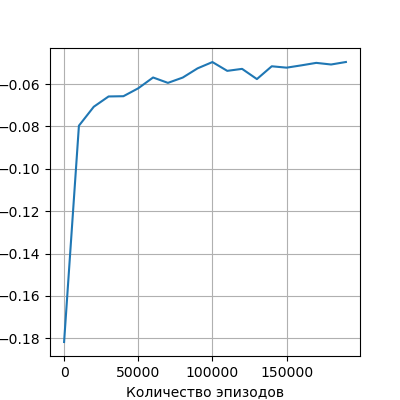

In [17]:
draw(hist['step'], hist['reward'])

In [18]:
ag1.eps=0
average_reward(gym.make('Blackjack-v0'), ag1, 1000000)

-0.049148

# Часть 2

In [19]:
#с возможностью даблиться
from BlackJack_part2 import BlackJack as bj2

In [20]:
dim = (32, 11, 2, 2)
na = 3
env = bj2()
ag2, hist2 = mc_control(env, dim, na, 500000, omega=1, eps=0.3)


100%|█████████████████████████████████| 500000/500000 [07:19<00:00, 1138.00it/s]


<IPython.core.display.Javascript object>


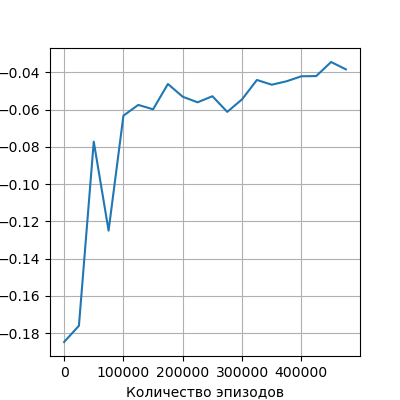

In [21]:
draw(hist2['step'], hist2['reward'])

In [22]:
ag2.eps=0
average_reward(bj2(), ag2, 1000000)

-0.03906

## Часть 3

Подсчёт осуществляется системой "Половинки" из википедии
Карты	         Числовые значения <br>
2	              +0,5<br>
3, 4	          +1<br>
5	              +1,5<br>
6	              +1<br>
7	              +0,5<br>
8	               0<br>
9	              −0,5<br>
10, В, Д, К, Т	  −1<br>

от -22 до 24 возможные суммы c учетом серединных значений <br>
от -44 до 48 - только целые<br>
тогда число состояний можно выразить как массив длинной 93. числа от 0 до 48 записываются как обычно, 
а от -1 до -44 с обратной стороны массива (так реализван питон)<br>
Подсчёт реализован в самой среде (файл BlackJack_part3). В жизни это должен делать агент, но по большому счёту для обучения модели большой разницы нет, а перекладывание этой ответственности на среду позволяет сделать процесс обучения удобнее и наимение отличимым от части 1 и части 2.


In [23]:
from BlackJack_part3 import BlackJack as bj3

In [24]:
dim = (32, 11, 2, 2, 93)
na = 3
env = bj3()
ag3, hist3 = mc_control(env, dim, na, 10*int(1e6), omega=1, eps=0.3)


100%|█████████████████████████████| 10000000/10000000 [22:17<00:00, 7474.38it/s]


<IPython.core.display.Javascript object>


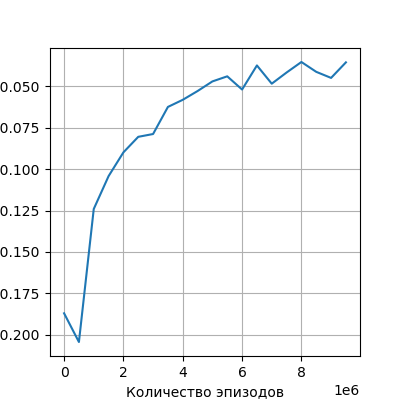

In [27]:
draw(hist3['step'], hist3['reward'])

In [26]:
ag3.eps=0
average_reward(bj3(), ag3, 1000000)

-0.039674

Казино обыграть не получилось:( И улучшения не сильно влияют на средний скор, но при этом требуют больше эпизодов для обучения.